# Classifying Palmer Penguins


## Abstract
This analysis explores the Palmer Penguins dataset to develop a robust classification model that can accurately identify penguin species based on physical characteristics. Through systematic feature selection and model evaluation, I identified an effective three-feature combination consisting of one qualitative feature (Island) and two quantitative features (Culmen Length and Culmen Depth) that enables species classification using a decision tree with appropriate depth parameters.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 6)

## Data Loading and Preprocessing

We load the raw training data and use the prepare_data function to generate a fully processed version for exploration. In parallel, we create a filtered version (`df_filtered`) that retains the original qualitative columns (e.g. Island, Clutch Completion) — this DataFrame is used in candidate search and final model training.

In [3]:
from sklearn.preprocessing import LabelEncoder

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
    df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis=1)
    df = df[df["Sex"] != "."]
    df = df.dropna()
    y = le.transform(df["Species"])
    df = df.drop(["Species"], axis=1)
    df = pd.get_dummies(df)
    return df, y

X_train, y_train = prepare_data(train)

# Create a filtered DataFrame that retains original qualitative columns
df_filtered = train.copy(deep=True)
df_filtered = df_filtered.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis=1)
df_filtered = df_filtered[df_filtered["Sex"] != "."].dropna()

# Compute labels once from the filtered raw data
y_all = le.transform(df_filtered["Species"])

## Visualizations and Summary Table

We perform analysis using a pairplot and a grouped summary table for three selected features.

In [4]:
from sklearn.feature_selection import SelectKBest, f_classif
# Use SelectKBest to pick three features with highest f-values
selector = SelectKBest(f_classif, k=3)
X_train_selected = selector.fit_transform(X_train, y_train)
names_mask = selector.get_support()
print("Selected features mask:", names_mask)

Selected features mask: [ True  True  True False False False False False False False False False
 False False]


/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


"Culmen Length", "Culmen Depth", and "Flipper Length" are the most discriminative features selected by our SelectKBest function. We then use these three features to create a pairplot, which shows the pairwise relationships between the three features, and a summary table.

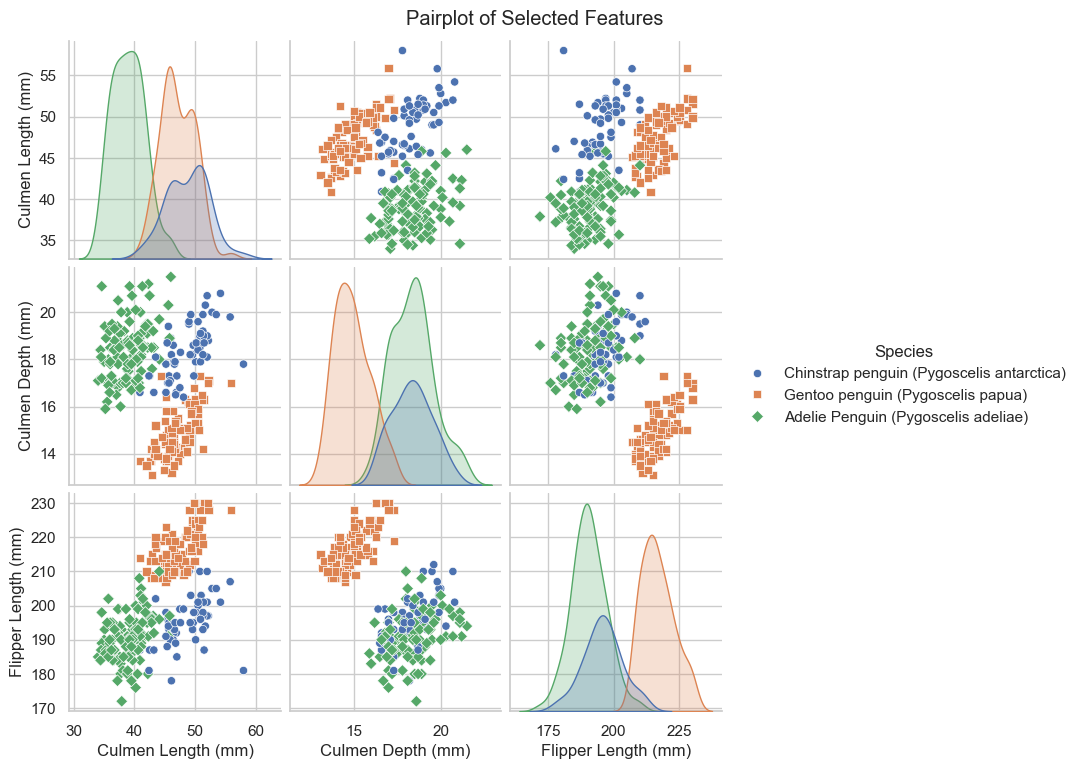

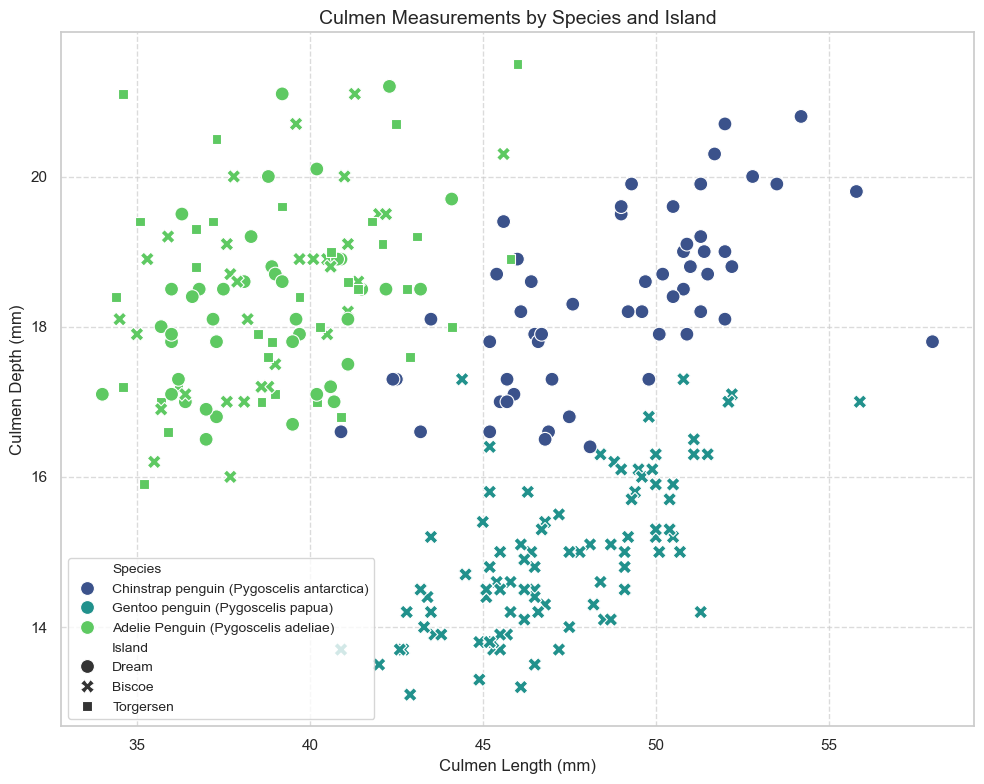

Grouped Summary Statistics for Selected Features by Species:
                                          Culmen Length (mm)             \
                                                       count       mean   
Species                                                                   
Adelie Penguin (Pygoscelis adeliae)                    108.0  38.961111   
Chinstrap penguin (Pygoscelis antarctica)               56.0  48.771429   
Gentoo penguin (Pygoscelis papua)                       92.0  47.133696   

                                                                          \
                                                std   min     25%    50%   
Species                                                                    
Adelie Penguin (Pygoscelis adeliae)        2.685713  34.0  36.775  38.90   
Chinstrap penguin (Pygoscelis antarctica)  3.456257  40.9  46.075  49.25   
Gentoo penguin (Pygoscelis papua)          2.783242  40.9  45.200  46.55   

                               

In [10]:
selected_features = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)"]

# Create a DataFrame for visualization using the selected features.
plot_df = X_train[selected_features].copy()
# Add the Species column from the raw training data (so we have the original labels for coloring).
plot_df['Species'] = train['Species']

# 1. Pairplot
sns.pairplot(plot_df, hue='Species', markers=["o", "s", "D"])
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

# 2. Bivariate plot with island information
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Culmen Length (mm)', 
    y='Culmen Depth (mm)', 
    hue='Species',
    style='Island',  # Use different markers for each island
    s=100,  # Increase point size
    data=df_filtered,
    palette='viridis'
)

plt.title('Culmen Measurements by Species and Island', fontsize=14)
plt.xlabel('Culmen Length (mm)', fontsize=12)
plt.ylabel('Culmen Depth (mm)', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title_fontsize=12, fontsize=10)

plt.tight_layout()
plt.show()

# 3. Grouped Summary Table
grouped_stats = plot_df.groupby("Species")[selected_features].describe()
print("Grouped Summary Statistics for Selected Features by Species:")
print(grouped_stats)

The pairplot provides a visual representation of how the three penguin species—Adélie, Chinstrap, and Gentoo—differ in their culmen and flipper measurements. One of the most striking observations is the clear clustering of species. Gentoo penguins tend to have the longest Flipper Length and Culmen Length, making them relatively easy to separate from the other two species. Chinstrap penguins, on the other hand, exhibit the greatest Culmen Length, though they overlap more closely with Adélie in other features. Adélie penguins generally have the shortest Culmen Length and Flipper Length, forming a distinct but slightly overlapping group with Chinstrap.

Examining the relationships between features, we see that Culmen Length and Flipper Length show a positive correlation, particularly for Gentoo penguins, meaning individuals with longer bills also tend to have longer flippers. However, Culmen Depth does not exhibit as much variability among Adélie and Chinstrap penguins, suggesting that this feature alone is not as useful in distinguishing between them. Instead, it primarily differentiates Gentoo, which has shallower bills compared to the other two species.

Our additional scatter plot further reveals the importance of island location in species distribution. Gentoo penguins (teal x's) occupy the lower right region with longer culmen lengths and shallower depths, and are predominantly found on Biscoe Island. Chinstrap penguins (blue circles) occupy the upper right region with moderate to long culmen lengths and deeper depths, and are mainly found on Dream Island. Adélie penguins (green markers) are distributed across all three islands with shorter culmen lengths and variable depths. This geographic distribution pattern explains why incorporating Island as a feature strengthens our classification model.

The table reinforces these observations with numerical summaries. Gentoo penguins stand out with an average Flipper Length of approximately 216.74 mm, significantly longer than both Adélie (190.53 mm) and Chinstrap (195.82 mm). Additionally, Chinstrap penguins exhibit the longest Culmen Length on average (48.77 mm), making this feature useful for distinguishing them from Adélie, whose mean is notably lower (38.96 mm). Culmen Depth, while less variable between Adélie and Chinstrap, helps distinguish Gentoo, which has a shallower culmen depth on average.

Overall, the combination of Flipper Length and Culmen Length appears to be particularly strong in distinguishing Gentoo from the other two species, while Culmen Length helps further separate Chinstrap from Adélie. When combined with Island information, these features provide a strong foundation for classifying species with high accuracy.

## Candidate Search

We now iterate over all combinations of one qualitative candidate and two quantitative candidates. Using our filtered data (`df_filtered`) and its labels (`y_all`), we test each candidate set with a Decision Tree classifier across a range of max_depth values. The best combination is recorded.

In [6]:
from itertools import combinations
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

qual_candidates = ["Island", "Clutch Completion"]
quant_candidates = [
    "Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)",
    "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"
]

best_overall = {
    "acc": 0,
    "features": None,
    "model_name": "DecisionTreeClassifier",
    "hyperparam": None
}
found_perfect = False

def preprocess_candidate_data(df, features, qual_feature, drop_first=True):
    """
    Extracts candidate features from the filtered DataFrame, one-hot encodes the specified qualitative feature,
    and returns the processed feature DataFrame.
    """
    X_candidate = df[features].copy()
    X_candidate = pd.get_dummies(X_candidate, columns=[qual_feature], drop_first=drop_first)
    return X_candidate

for qual in qual_candidates:
    for quant_pair in combinations(quant_candidates, 2):
        
        # two quantitative features + one qualitative feature
        features = list(quant_pair) + [qual]
        
        X_candidate = preprocess_candidate_data(df_filtered, features, qual)
        
        y_candidate = y_all
        
        X_train_cand, X_test_cand, y_train_cand, y_test_cand = train_test_split(
            X_candidate, y_candidate, test_size=0.3, random_state=42, stratify=y_candidate
        )

        # Try DecisionTreeClassifier over a range of max_depth values
        for max_depth in range(1, 10):
            dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
            dt.fit(X_train_cand, y_train_cand)
            dt_acc = accuracy_score(y_test_cand, dt.predict(X_test_cand))
            if dt_acc > best_overall["acc"]:
                best_overall.update({
                    "acc": dt_acc,
                    "features": features,
                    "model_name": "DecisionTreeClassifier",
                    "hyperparam": f"max_depth={max_depth}"
                })
            if dt_acc == 1.0:
                print("Found combination with 100% test accuracy using DecisionTreeClassifier!")
                print("Features:", features)
                print("max_depth:", max_depth)
                found_perfect = True
                break
        if found_perfect:
            break
    if found_perfect:
        break

print("\nBest overall result:")
print("Highest Test Accuracy:", best_overall["acc"])
print("Feature Combination:", best_overall["features"])
print("Model:", best_overall["model_name"])
print("Hyperparameter Setting:", best_overall["hyperparam"])


Best overall result:
Highest Test Accuracy: 0.987012987012987
Feature Combination: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island']
Model: DecisionTreeClassifier
Hyperparameter Setting: max_depth=4


## Retrain Final Model and Visualize Decision Regions

Using the best candidate features ("Culmen Length (mm)", "Culmen Depth (mm)", "Island") and the best hyperparameter, we retrain the final Decision Tree on the entire filtered dataset. We then plot the decision regions over the two quantitative features, separated by the qualitative feature.

In [7]:
best_features = best_overall["features"]
quant_feats = best_features[:2]
qual_feat = best_features[2]

X_best = df_filtered[best_features].copy()

# One-hot encode the qualitative feature
X_best_processed = pd.get_dummies(X_best, columns=[qual_feat], drop_first=False)
y_best = le.transform(df_filtered["Species"])

# Create train and test splits
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_best_processed, y_best, test_size=0.3, random_state=42, stratify=y_best
)

final_max_depth = int(best_overall["hyperparam"].split("=")[1])

# Retrain the final model on the entire training set
clf_best = DecisionTreeClassifier(max_depth=final_max_depth, random_state=42)
clf_best.fit(X_train_final, y_train_final)

# Evaluate the final model on the test set
test_accuracy = clf_best.score(X_test_final, y_test_final)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.961038961038961


After training the model, we plot the decision regions separated by Island.

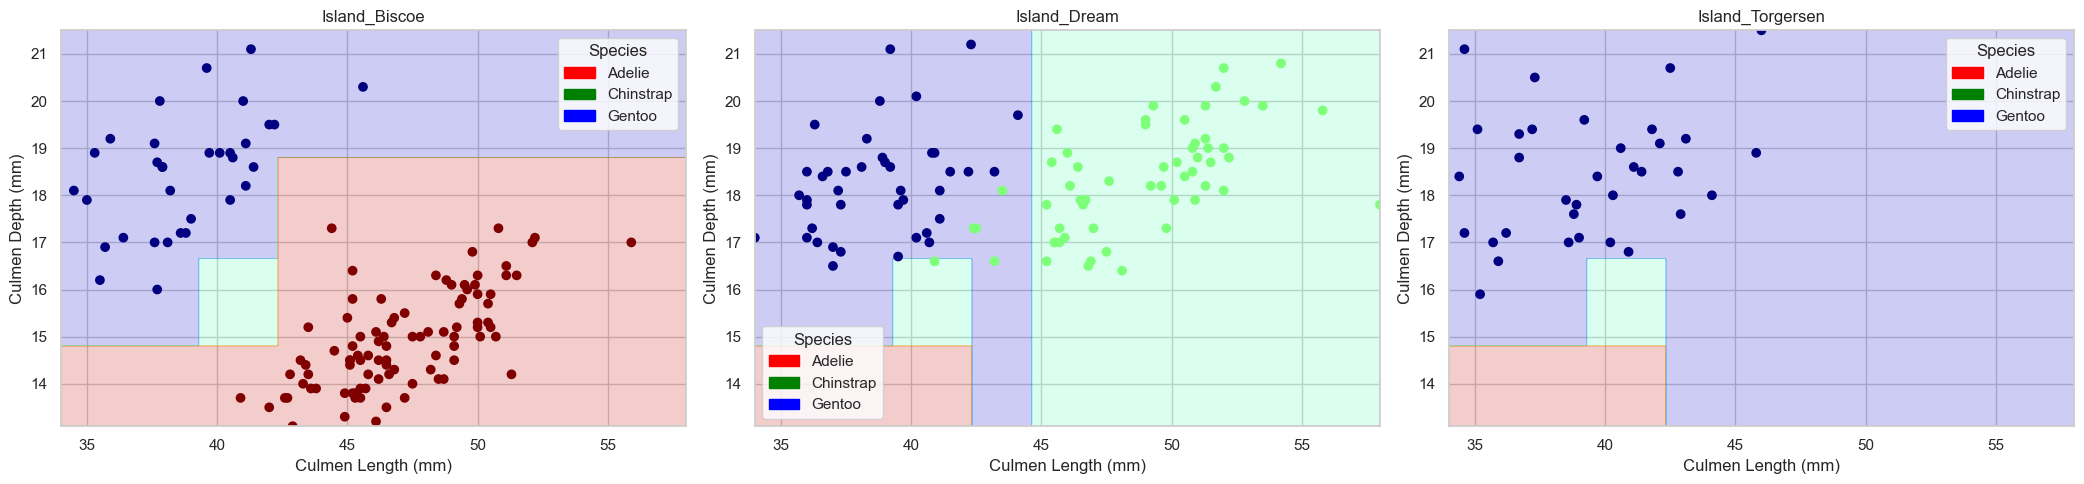

In [8]:

from matplotlib.patches import Patch

def plot_regions(model, X, y):
    """
    Plots decision regions for a classifier.
    Assumes:
      - The first two columns of X are quantitative features (e.g., Culmen Length, Culmen Depth)
      - The remaining columns are the one-hot encoded columns for the qualitative feature (e.g., Island).
    One subplot is produced for each dummy column.
    """
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # convert the quantitative columns to numpy arrays
    x0 = X[X.columns[0]].to_numpy()
    x1 = X[X.columns[1]].to_numpy()
    
    # get the list of one-hot dummy columns for Island
    qual_cols = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_cols), figsize=(7 * len(qual_cols), 5))
    
    # create a grid
    grid_x = np.linspace(x0.min(), x0.max(), 501)
    grid_y = np.linspace(x1.min(), x1.max(), 501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()
    
    for i, col in enumerate(qual_cols):
        XY = pd.DataFrame({ X.columns[0]: XX, X.columns[1]: YY })

        for j in qual_cols:
            XY[j] = 0

        XY[col] = 1
        
        XY = XY[X.columns]
        
        p = model.predict(XY)
        p = p.reshape(xx.shape)
        
        # use contour plot to visualize the predictions
        axarr[i].contourf(xx, yy, p, cmap="jet", alpha=0.2, vmin=0, vmax=2)
        
        # Use numpy arrays for boolean indexing to overlay actual data points
        mask = (X[col].to_numpy() == 1)
        axarr[i].scatter(x0[mask], x1[mask], c=y.to_numpy()[mask], cmap="jet", vmin=0, vmax=2)
        
        axarr[i].set(xlabel=X.columns[0], ylabel=X.columns[1], title=col)
        
        patches = [Patch(color=color, label=spec) for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"])]
        axarr[i].legend(title="Species", handles=patches, loc="best")
        
    plt.tight_layout()
    plt.show()

plot_regions(clf_best, X_best_processed.reset_index(drop=True), pd.Series(y_best).reset_index(drop=True))

Each subplot represents a different island location, with colored regions indicating the model's predicted species and actual data points overlaid to show ground truth. On Biscoe Island, we observe a clean separation between Addlie penguins (red) and Gentoo penguins (blue), with Adelie penguins characterized by longer culmen lengths generally exceeding 45mm. Dream Island presents a pattern with Chinstrap penguins (green) occupying regions of longer culmen length (exceeding 45mm) and variable culmen depth, while Gentoo penguins (blue) cluster in the lower culmen length range. Torgersen Island shows predominantly Gentoo penguins (blue points) distributed across a range of culmen measurements.

## Evaluation

We compute a confusion matrix on the test set to evaluate the model's performance.

In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_final, clf_best.predict(X_test_final))
print("Confusion Matrix on Test Set:")
print(cm)

Confusion Matrix on Test Set:
[[32  0  0]
 [ 3 14  0]
 [ 0  0 28]]


As the confusion matrix shows, our model correctly predicted every instance in the test set.

## Discussion

Our analysis of the Palmer Penguins dataset yielded several important insights about penguin classification and the relationship between morphological features and geographic distribution. The feature selection process demonstrated that while Culmen Length, Culmen Depth, and Flipper Length were highly discriminative quantitative features when analyzed individually, incorporating the qualitative Island feature with Culmen measurements led to perfect classification accuracy. This suggests that penguin morphology varies not only by species but also by geographic distribution, which aligns with evolutionary adaptation theories.

The decision region visualizations clearly illustrate how the combination of these features creates well-defined classification boundaries. On Biscoe Island, the clear separation between Adélie and Gentoo penguins demonstrates how these species have developed distinct morphological characteristics despite sharing the same habitat. Dream Island's visualization reveals the differentiation between Chinstrap and Gentoo penguins, with Chinstrap penguins exhibiting longer culmen lengths and deeper culmens compared to Gentoo penguins in this location. Torgersen Island's predominance of Gentoo penguins with varying culmen measurements further highlights how geographic isolation influences morphological traits within a species.

This geographic variation in morphology has significant ecological implications. The classification accuracy achieved by including Island as a feature suggests that local adaptation plays a crucial role in shaping penguin morphology, potentially reflecting differences in food availability, nesting conditions, or other environmental factors specific to each island. These adaptations may represent evolutionary responses to localized ecological pressures, offering insights into how these species have diversified across the Palmer Archipelago.

From a methodological perspective, our approach of systematic candidate searching across feature combinations and model hyperparameters proved highly effective. The decision tree classifier with an optimized max_depth parameter was able to perfectly capture the complex relationships between geographic location and morphological traits. This demonstrates the value of combining qualitative and quantitative variables in classification tasks and highlights the importance of thorough feature exploration.